In [1]:
#########################################################################################
# Authors: Lorenzo Schellack, Martin Rejhon, and Nitika Parashar
# Last Modified: January 26, 2024
#
# Description:
# This code is designed to recieve a .txt file and perform analysis to extract 
# Young's Modulus from Modulated Nanoindentation (MoNI) Experiments
#
# Reference:
# Cellini F., Gao Y., Riedo E. (2019). 
# 'Å-Indentation for non-destructive elastic moduli measurements 
# of supported ultra-hard ultra-thin films and nanostructures'
# DOI: https://doi.org/10.1038/s41598-019-40636-0
#
# Contact: lms9992@nyu.edu (Lorenzo Schellack)
#          martin.rejhon@matfyz.cuni.cz (Martin Rejhon)    
#          np2227@nyu.edu (Nitika Parashar)
#
# License: GPL-3.0
#########################################################################################

In [2]:
# Necessary dependencies for running code
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy import integrate

In [3]:
# Methods

def loadFile(doc):
    # Loads experimental data using 'doc' as the .txt filepath
    file = open(doc, 'r')
    linesArray = file.readlines()
    lineNum = 0
    
    # Finds starting position of the data after the header
    for i in enumerate(linesArray):
        if i[1].split()[0] == 'Time':
            lineNum = i[0] + 1
            
    # Save data without header
    data = np.genfromtxt(doc,skip_header = lineNum)
    return data

def findNearest(array, value):
    # Returns element of array closest to 'value'
    element = (np.abs(array-value)).argmin()
    return element
    
def hertzEqn(Z,E,R):
    # Hertz equation to be used for scipy curve fitting (Eqn 6 in ref.)
    F = 4/3*E*np.sqrt(R)*Z**(3/2)
    return F

def modulusEqn(eStar,vSample,vTip,eTip):
    # Equation for determining the Young's Modulus (Eqn 8 in ref.)
    x = (1/eStar-(1-vTip**2)/eTip)
    eSample = (1-vSample**2)/x
    return eSample

def findStart(X):
    # Method for finding 'pull-off' point on a force-distance plot,
    # by extracting the position of largest change in the data
    pos = np.argmax(abs(np.diff(X)))
    return pos

In [4]:
# Various parameters and constants

Wn = 65e-9 # Cantilever sensitivity obtained from force-distance curve measurement (nm/V)
sLockin = 100e-5 # Lock-in amplifier sensitivity (V)
dzPiezo = 1.8e-10 # Depth measured by piezo (angstrom)
depth = 10 # How far to perform fitting procedure (angstrom)

end = 216 # Integration end point index 

kLev = 95 # Cantilever spring constant (N/m)
tipRadius = 55 # Tip radius (nm)
tipModulus = 1050 # Young's Modulus of the Tip (GPa)
vTip = 0.2 # Poisson's ratio of the Tip
vSample = 0.2 # Poisson's ratio of the Sample

fitCurve = True # Boolean for curve fitting procedure

In [5]:
data = loadFile("change this to filepath of MoNI data")

# Assign dataset columns to individual arrays
time = data[:,0]
SpV = data[:,1]
DeltaV = data[:,2]
RawDef = data[:,3]

# Find integration start point (pull-off point on force-distance curve)
start = findStart(RawDef)

# Cut and reverse arrays according to ending and starting points
setpoint = np.asarray(SpV[end:start])
vDef = np.asarray(DeltaV[end:start])
vDef = vDef*(sLockin/10)
vDefRaw = np.asarray(RawDef[end:start])

# Calculations

dzLev = 2*np.sqrt(2)*Wn*vDef 
dF = kLev*dzLev
kTot = dF/dzPiezo # (Eqn 2 in ref.)
kCont = 1 / ((1 / kTot) - (1 / kLev)) # (Eqn 3 in ref.)

F = setpoint*kLev*Wn # Force array
F0 = (F-np.min(F))*1e9 # Zeroed force array

z = integrate.cumulative_trapezoid(1/kCont, x = F0*1e-9, dx = np.abs(F0[1]-F0[0])*1e-9, initial = 0) # (Eqn 4 in ref.)
z0 = (z-np.min(z))*1e10 # Zeroed contact indentation array

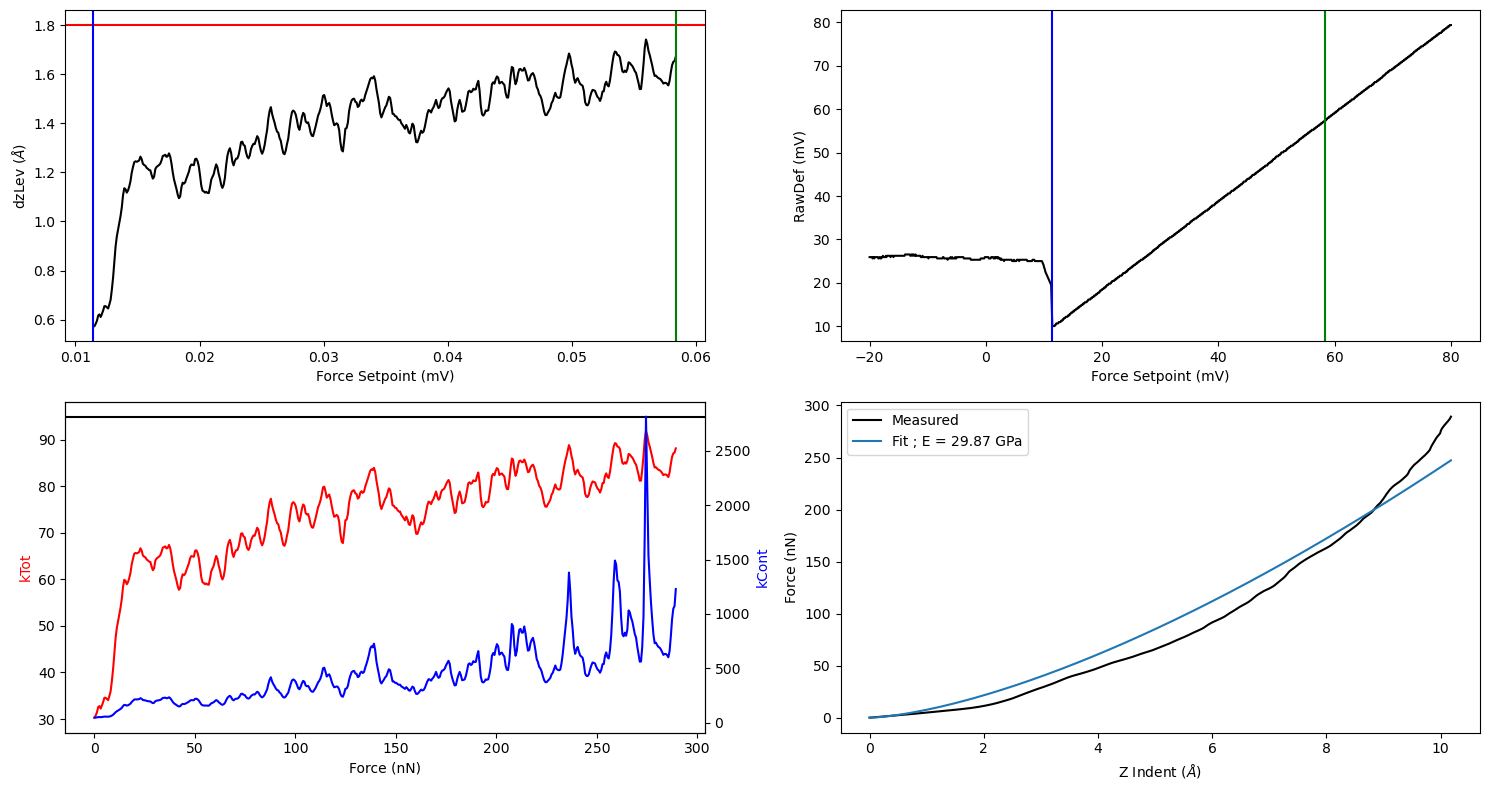

In [7]:
# Plotting with matplotlib

figure = plt.figure(figsize = (15,8))
grid = gridspec.GridSpec(2,2)

plt1 = figure.add_subplot(grid[0,0])
plt2 = figure.add_subplot(grid[0,1])
plt3 = figure.add_subplot(grid[1,0])
plt4 = figure.add_subplot(grid[1,1])

# Plot 1: Raw deflection setpoint vs. signal from lock-in
plt1.plot(setpoint,dzLev*1e10, 'k-')
plt1.axhline(dzPiezo*1e10, color = 'r')
plt1.axvline(SpV[start], color = 'b')
plt1.axvline(SpV[end], color = 'g')
plt1.set_xlabel('Force Setpoint (mV)')
plt1.set_ylabel(r'dzLev ($\AA$)')

# Plot 2: Force setpoint vs. Raw Deflection
plt2.plot(SpV*1e3,RawDef*1e3, 'k-')
plt2.axvline(SpV[start]*1e3, color = 'b')
plt2.axvline(SpV[end]*1e3, color = 'g')
plt2.set_xlabel('Force Setpoint (mV)')
plt2.set_ylabel(r'RawDef (mV)')

# Plot 3: Total spring constant vs. Force
plt3.plot(F0, kTot, 'r-')
plt3.axhline(kLev, color = 'k')
plt33 = plt3.twinx()
plt33.plot(F0, kCont, 'b')
plt33.set_ylabel('kCont', c = 'b')
plt3.set_ylabel('kTot', c = 'r')
plt3.set_xlabel('Force (nN)')

# Plot 4: Force distance curve
plt4.plot(z0, F0, 'k-', label = 'Measured')
plt4.set_ylabel('Force (nN)') 
plt4.set_xlabel('Z Indent ($\AA$)')

# Plot 4: Curve fitting
if fitCurve == True:
    depthPosition = findNearest(z0[::-1], depth)
    fitParameters, fitCovariance = curve_fit(hertzEqn, z0[::-1][:depthPosition]/10, F0[::-1][:depthPosition], bounds = ([1,(tipRadius-20)],[2000,(tipRadius)+20]))
    stdDeviation = np.sqrt(np.diag(fitCovariance))
    
    plt4.plot(z0, hertzEqn(z0/10, *fitParameters), label = 'Fit ; E = '+str(round(modulusEqn(fitParameters[0],vSample,vTip,tipModulus), 2))+' GPa')
    plt4.legend(loc = 'best')
    #print(modulusEqn(fitParameters[0],vSample,vTip,tipModulus))
    
plt.tight_layout()
plt.show()